# DeepDream

We'll describe an implementation of DeepDream.

In [1]:
import sys
sys.path.insert(0, "../../../")

## Load Data

We'll load the example image of the Drosophila ssTEM dataset from https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713. Alternatively, you can download an image from the corresponding GiHub repository: http://github.com/unidesigner/groundtruth-drosophila-vnc.

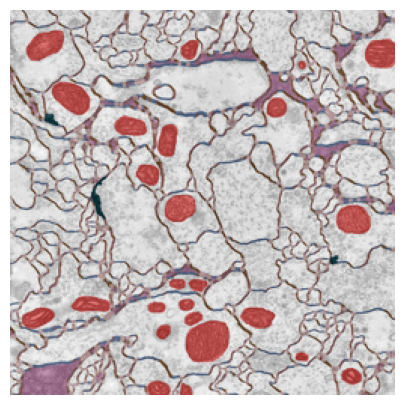

In [2]:
from PIL import Image
from urllib.request import urlopen
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

url = 'https://s3-eu-west-1.amazonaws.com/pfigshare-u-previews/1288336/preview.jpg'
im = Image.open(urlopen(url)).resize((256,256))

from matplotlib import pyplot as plt
plt.figure(figsize=(5, 5))
plt.imshow(im)
plt.axis('off')
plt.show()

We'll download a pretrained model (VGG16) and freeze the layers

In [3]:
import torchvision.models as models
model = models.vgg16(pretrained=True)

# for param in model.parameters():
#     param.requires_grad_(False)

print(model)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [44]:
def deepdream(im, test_layer, num_iterations=100, step_size=0.01):

    import torch
    from deepdream import fwd_hooks, preprocess, deprocess
    import numpy as np
    from PIL import Image

    image = preprocess(im)
    model.eval()
    for t in range(num_iterations):
 
        with fwd_hooks(test_layers) as fh:
            out = model(image)

        loss = 0 
        for f in fh.stored:
            loss += f.mean()
        loss.backward()

        image.data += step_size*((image.grad.data - torch.mean(image.grad.data) )/(torch.std(image.grad.data)+1e-8))
        image.grad.data.zero_()

        #image.data.clamp_(min=-1, max=1)
    #return deprocess(image.data.clone().detach()), t
    return Image.fromarray(np.uint8(np.clip(deprocess(image.data.clone().detach())*255,0,255)), 'RGB'), t

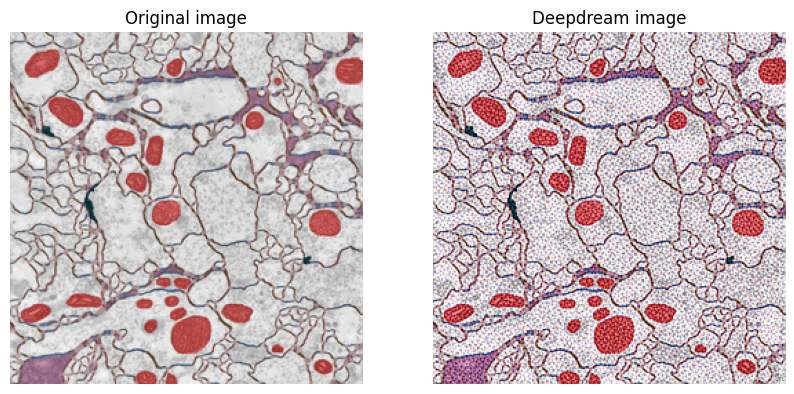

In [45]:
from deepdream import plot_dream
test_layers = [model.features[4]]
im_out, num_iter  =  deepdream(im, test_layers, num_iterations=50, step_size=.01)
plot_dream(im, im_out)

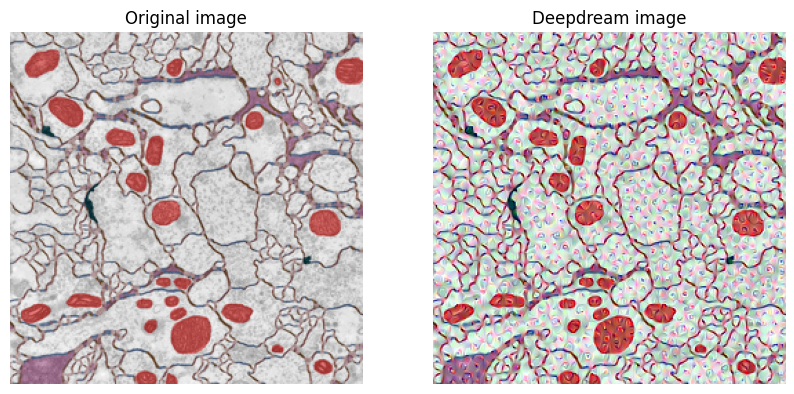

In [46]:
from deepdream import plot_dream
test_layers = [model.features[9]]
im_out, num_iter  =  deepdream(im, test_layers, num_iterations=50, step_size=.01)
plot_dream(im, im_out)

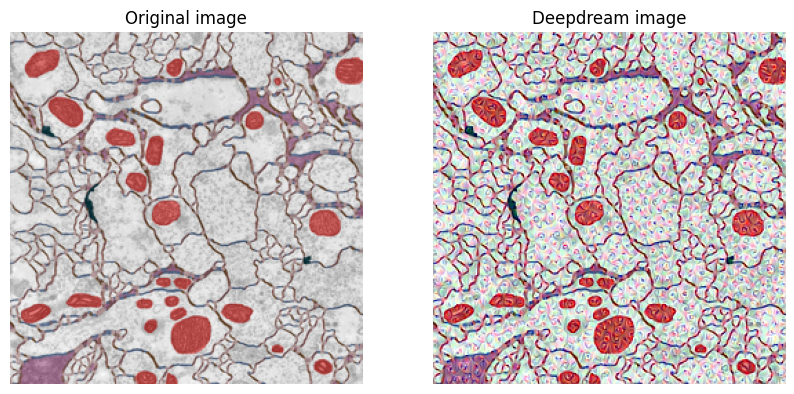

In [49]:
test_layers = [ model.features[4], model.features[9]]

im_out, num_iter  =  deepdream(im, test_layers, num_iterations=50, step_size=0.01)

plot_dream(im, im_out)

Octaves

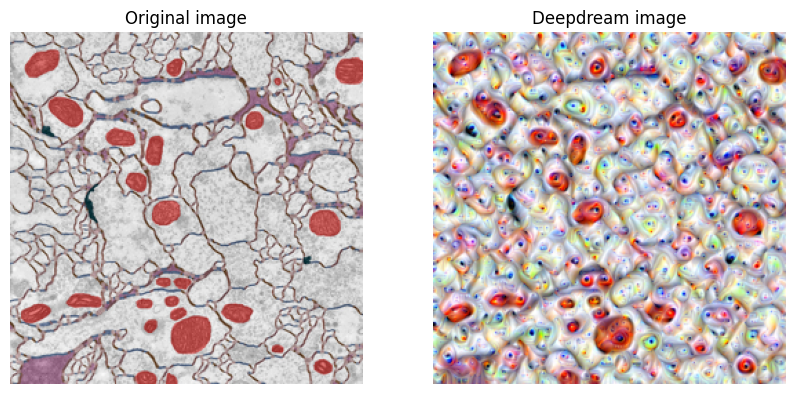

In [35]:
octave_scale = 1.4
im_oct = im
test_layers = [ model.features[16]]

for n in range(-2,3):
    im_oct = im_oct.resize((int(im.size[0]*(octave_scale**n)),int(im.size[1]*(octave_scale**n))))
    im_oct, _  =  deepdream(im_oct, test_layers, num_iterations=50, step_size=.01)
    im_oct = im_oct.resize(im.size)

plot_dream(im, im_oct)